# Variational Autoencoder for MNIST

In [1]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms

/apps/daint/UES/6.0.UP04/sandboxes/sarafael/ml2024/lib/python3.9/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


Let's import the usual Python suspects:

In [2]:
import numpy as np

In [3]:
import tqdm

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In order to avoid surprises due to the random initialization of weights in our models, we set the random seed. See [PyTorch: Reproducibility](https://pytorch.org/docs/stable/notes/randomness.html) for more details.

In [5]:
import random

seed = 42

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Description

In this notebook, we are going to build a Variational Autoencoder (VAE) to generate new images that look like the ones contained in the [MNIST]() dataset.

### GPU

Before we start, let's define the `torch.device` we will use for training:

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Dataset

As we did previously, let's download the MNIST data set. However, since we are working with a generative model and trying to learn the underlying data distribution of the training set, we don't need to worry about the validation or test sets.

*Define a [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) from the `trainset` data set. Use the pre-defined `batch_size` (hyperparameter), and enable shuffling of the examples. Drop the last batch (with a different batch size), to make things easier (we hard-code `batch_size` in several places, and use it for assertions).*

In [7]:
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(), # Convert PIL image to PyTorch tensor
    transforms.Normalize(0.5, 0.5) # Normalise images: out = (in - mean) / std
])

trainset = datasets.MNIST(root="data/", train=True, download=True, transform=transform)

# Define the trainloader using a PyTorch DataLoader
# TODO
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)

trainiter = iter(trainloader)

It is always a good idea to have a look at the data. Let's plot a bunch of samples.

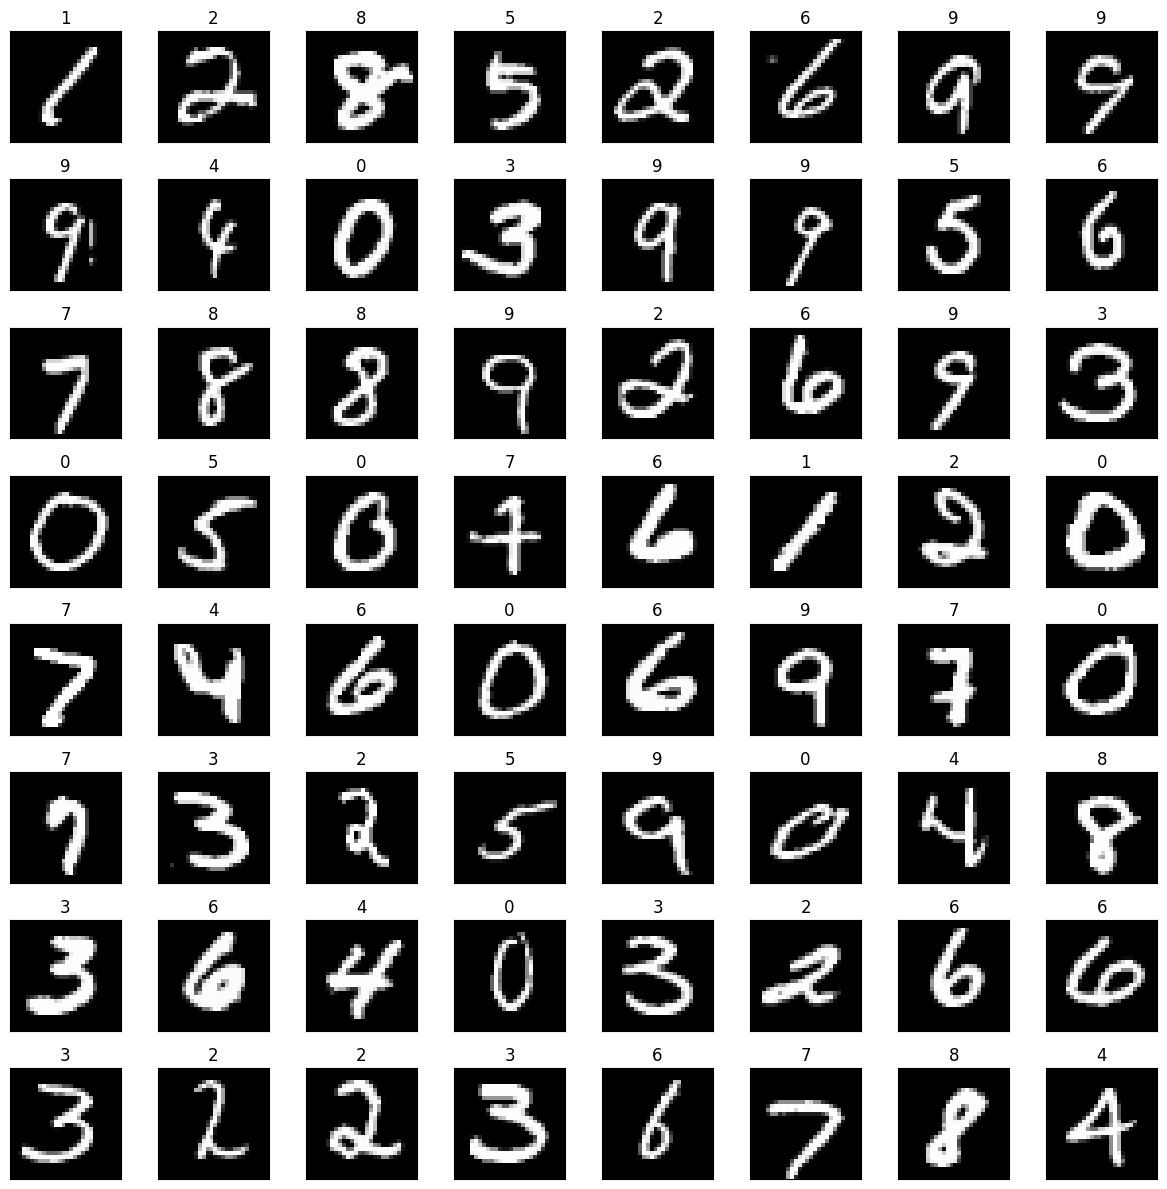

In [8]:
images, labels = next(trainiter)

fig = plt.figure(figsize=(12,12))
for idx in range(64):
    ax = fig.add_subplot(8, 8, idx + 1, xticks=[], yticks=[])
    
    img = images[idx].numpy()
    
    # Un-normalize the image
    img = img * 0.5 + 0.5 

    # Transpose image from C x H x W to H x W x C
    img = np.transpose(img, (1, 2, 0))
    
    plt.imshow(img, cmap='gray')
    
    name = str(labels[idx].item())
    
    ax.set_title(name, fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()

## Model

Let's define a fully connected variational autoencoder. The size of the latent space is a parameter of the model architecture.

*The encoder should be composed by linear layers with hidden dimensions `hidden_dim_1` and `hidden_dim_2`. Use `ReLU` activation functions between layers. The final layers produce what we interpret as a mean and log variance of a Gaussian distribution.*

*Implement the reparametrisation trick in the method `reparametrisation`.*

*Implement the decoder mirroring the encoder, but as a sequential model (since there is a single output). Use `tanh` as the ouptu activation function, to produce images in the range $[-1, 1]$.* 

*Implement the `encode` and `decode` functions. The `encode` function defines the forward pass of the encoder, and needs to take care of linearising the input (from 2D images to 1D vectors). The `decode` function defines the forward pass of the decoder, and needs to take care of reshaping the linear output into an image.*

*Use the `encode()`, `decode()` and `reparametrisation()` functions to define the `forward()` function.*

In [9]:
class VAE(nn.Module):
    def __init__(self, z_size):
        super().__init__()
        
        self.z_size = z_size
        
        hidden_dim_1 = 256
        hidden_dim_2 = 128
        
        # Define the encoder layers (using hidden_dim_1 and hidden_dim_2)
        # TODO
        self.enc_1 = nn.Linear(28*28, hidden_dim_1)
        self.enc_2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.enc_mean = nn.Linear(hidden_dim_2, z_size)
        self.enc_logvar = nn.Linear(hidden_dim_2, z_size)
        
        # Define the decoder
        # TODO
        self.decoder = nn.Sequential(
            nn.Linear(z_size, hidden_dim_2),
            nn.ReLU(),
            nn.Linear(hidden_dim_2, hidden_dim_1),
            nn.ReLU(),
            nn.Linear(hidden_dim_1, 28*28),
            nn.Tanh()
        )
        
    def encode(self, x):
        # Respahe the image into a linear vector
        # TODO
        x = x.view(-1, 1*28*28)
        
        # Apply encoder layers
        # TODO
        x = F.relu(self.enc_1(x))
        x = F.relu(self.enc_2(x))
        mean = self.enc_mean(x)
        logvar = self.enc_logvar(x)
        
        return mean, logvar
    
    def decode(self, z):
        # Apply decoder layers
        x_out = self.decoder(z)
        
        # Reshape output vector into an image (with one channel)
        x_out = x_out.view(-1, 1, 28, 28)
        
        return x_out
    
    def reparametrisation(self, mean, logvar):
        # Transform the logarithm of the variance into the standard deviation
        # TODO
        std = torch.exp(logvar/2)
        
        # Sample from the normal distribution
        # Hing: use randn_like
        # TODO
        e = torch.randn_like(mean)
        
        # Reparametrisation
        # TODO
        z = mean + std * e
        
        return z
    
    def forward(self, x):
        # Encode x
        # TODO
        mean, logvar = self.encode(x)
        
        # Reparametrisation trick
        # TODO
        z = self.reparametrisation(mean, logvar)
        
        # Decode z
        # TODO
        x_out = self.decode(z)
        
        return x_out, mean, logvar

Let's instantiate a VAE with a latent space dimension of 10 and check that the `forward()`, `encode()` and `decode()` functions produce outputs of the correct shape.

In [10]:
v = VAE(10)

In [11]:
v(torch.ones((batch_size, 1, 28, 28)))[0].shape

torch.Size([128, 1, 28, 28])

In [12]:
v.encode(torch.ones((batch_size, 1, 28, 28)))[0].shape

torch.Size([128, 10])

In [13]:
v.decode(torch.ones((batch_size, 10))).shape

torch.Size([128, 1, 28, 28])

## Training

In [14]:
# Latent vector size
z_size = 10

vae = VAE(z_size).to(device)

### Losses

As mentioned in the class, the variational autoencoder loss boils down to two terms: the _reconstruction loss_ (same as for an autoencoder) and the _Kullback–Leibler divergence_ loss. The latter can be computed analytically and it is given by
$$
   L =  -D_\text{KL}(q_\phi(\mathbf{z}|\mathbf{x})||p_\theta(\mathbf{z})) = - \frac{1}{2} \sum_j 
    \left(1 + \log\left(\sigma_j^2\right) - \mu_j^2 - \sigma_j^2\right)
$$

*Implement the loss function:*
  * _The reconstruction loss is the sum of squared difference between input and output_
  * _The KL loss is defined above_
  
_You can implement the reconstruction loss using PyTorch's `mse_loss`._

In [15]:
def loss_fn(x_out, x_in, mean, logvar, kl_weight=0.5):
    # Reconstruction loss
    # TODO
    reconstruction_loss = F.mse_loss(x_out, x_in, reduction="sum")
    
    # KL divergence
    # TODO
    kl_loss = -0.5 * torch.sum(1 + logvar - mean**2 - torch.exp(logvar))
    
    return reconstruction_loss + kl_weight * kl_loss

### Optimiser

For the oprimizer, we use again the [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimizer.

In [16]:
# Optimizers
lr = 1e-3

optimizer = optim.Adam(vae.parameters(), lr)

During training we will save some generated samples, in order to visualize how the training progressed ath the end. Therefore, we define a batch of fixed latent space vectors $z$ that we re-use each time:

In [17]:
# Fixed data for sampling new images (for evaluation)
sample_size = batch_size
fixed_z = torch.randn((sample_size, z_size)).to(device)

*Implement the missing bits from the training loop.*

In [18]:
from tqdm import trange, tqdm

n_epochs = 30

# Keep track of loss and generated, "fake" samples
samples = []

# Ensure the VAE is in training mode
# TODO
vae.train()

iters = 0
pbar = trange(n_epochs, desc='Training', leave=True)
for epoch in pbar:
    
    for images, _ in trainloader:
     
        x_in = images.to(device)
    
        # Clear gradients
        # TODO
        optimizer.zero_grad()

        # Forward pass
        # TODO
        x_out, mean, logvar = vae(x_in)
        
        # Loss
        # TODO
        loss = loss_fn(x_out, x_in, mean, logvar)
        
        # Backpropagation
        # TODO
        loss.backward()

        # Update weights
        # TODO
        optimizer.step()
        
        if iters % 250 == 0:
            # Generate fake images from fixed sample
            vae.eval()
            with torch.no_grad():
                samples.append(vae.decode(fixed_z))
            vae.train()

Training: 100%|██████████| 30/30 [07:04<00:00, 14.15s/it]


Now we can use the generator to generate new images. We generate new latent space samples $z$ and use the generator $G(z)$ to generate new images.

*Create a batch (`batch_size`) of samples of the latent space (using PyTorch's `randn`) and decode them.*

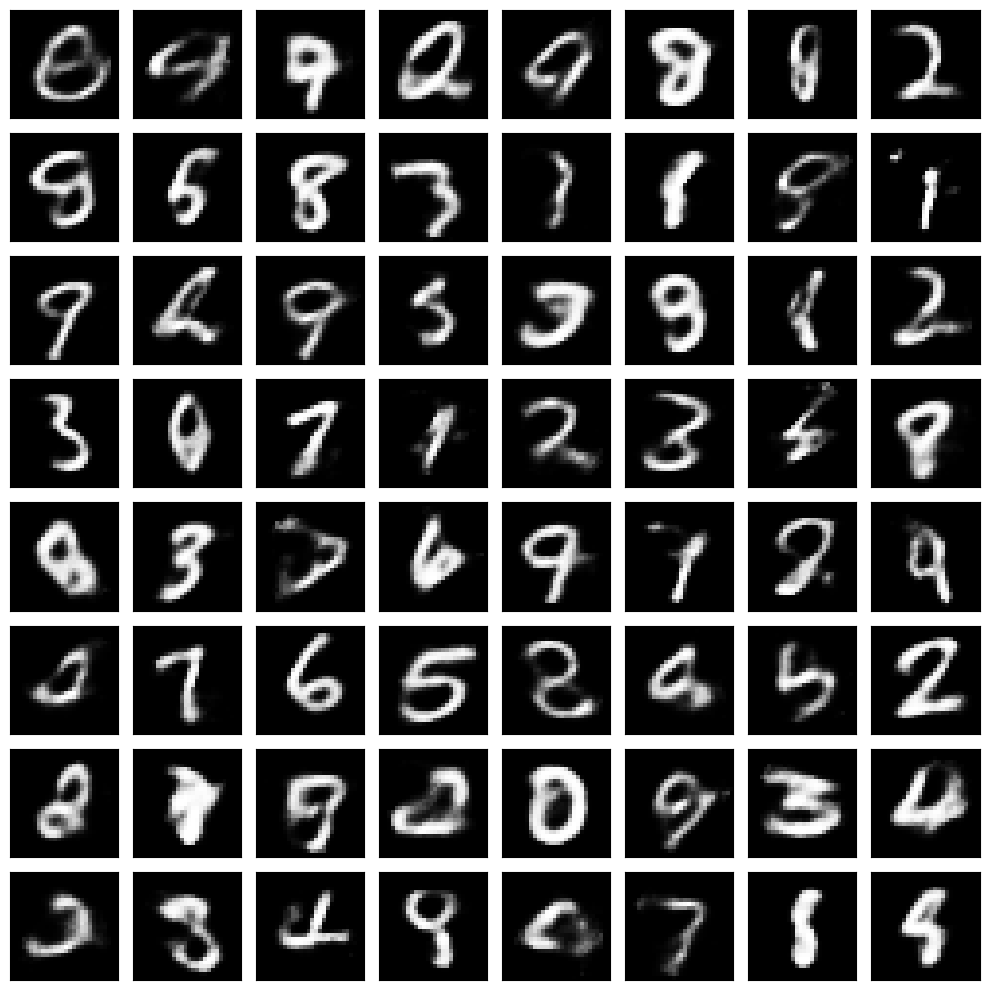

In [19]:
# Ensure the model is in evaluation mode
# TODO
vae.eval()

with torch.no_grad():
    # Create a batch of latent space samples
    # Hint: ensure they are on the appropriate device
    # TODO
    z = torch.randn((batch_size, z_size)).to(device) 
    
    # Decode z into images
    # TODO
    images = vae.decode(z)

fig = plt.figure(figsize=(10,10))
for idx in range(64):
    ax = fig.add_subplot(8, 8, idx + 1, xticks=[], yticks=[])

    img = images[idx].detach().cpu().numpy()
    
    img = img * 0.5 + 0.5
    
    img = np.transpose(img, (1, 2, 0))
    
    ax.imshow(img, cmap='gray')
    
    # Get name
    name = str(labels[idx].item())
    
plt.tight_layout()
plt.show()

As we can see, the generated images are pretty decent, compared to the real ones. This is especially true if we consider that the model is a feed-forward neural network.

*As an exercise, you can implement a convolutional encoder and a convolutional decoder and see if it improves the quality of the generated images.*

Since we stored some samples during training, we can also visualise how the generator evolves during training. On order to show more examples at the beginning of training, we use `np.logspace` to generate the indices of the time steps we want to visualize:

In [20]:
ss = np.logspace(0, np.log10(len(samples) - 1), num=10, dtype=int)
ss

array([    1,     2,     8,    24,    69,   201,   581,  1681,  4858,
       14039])

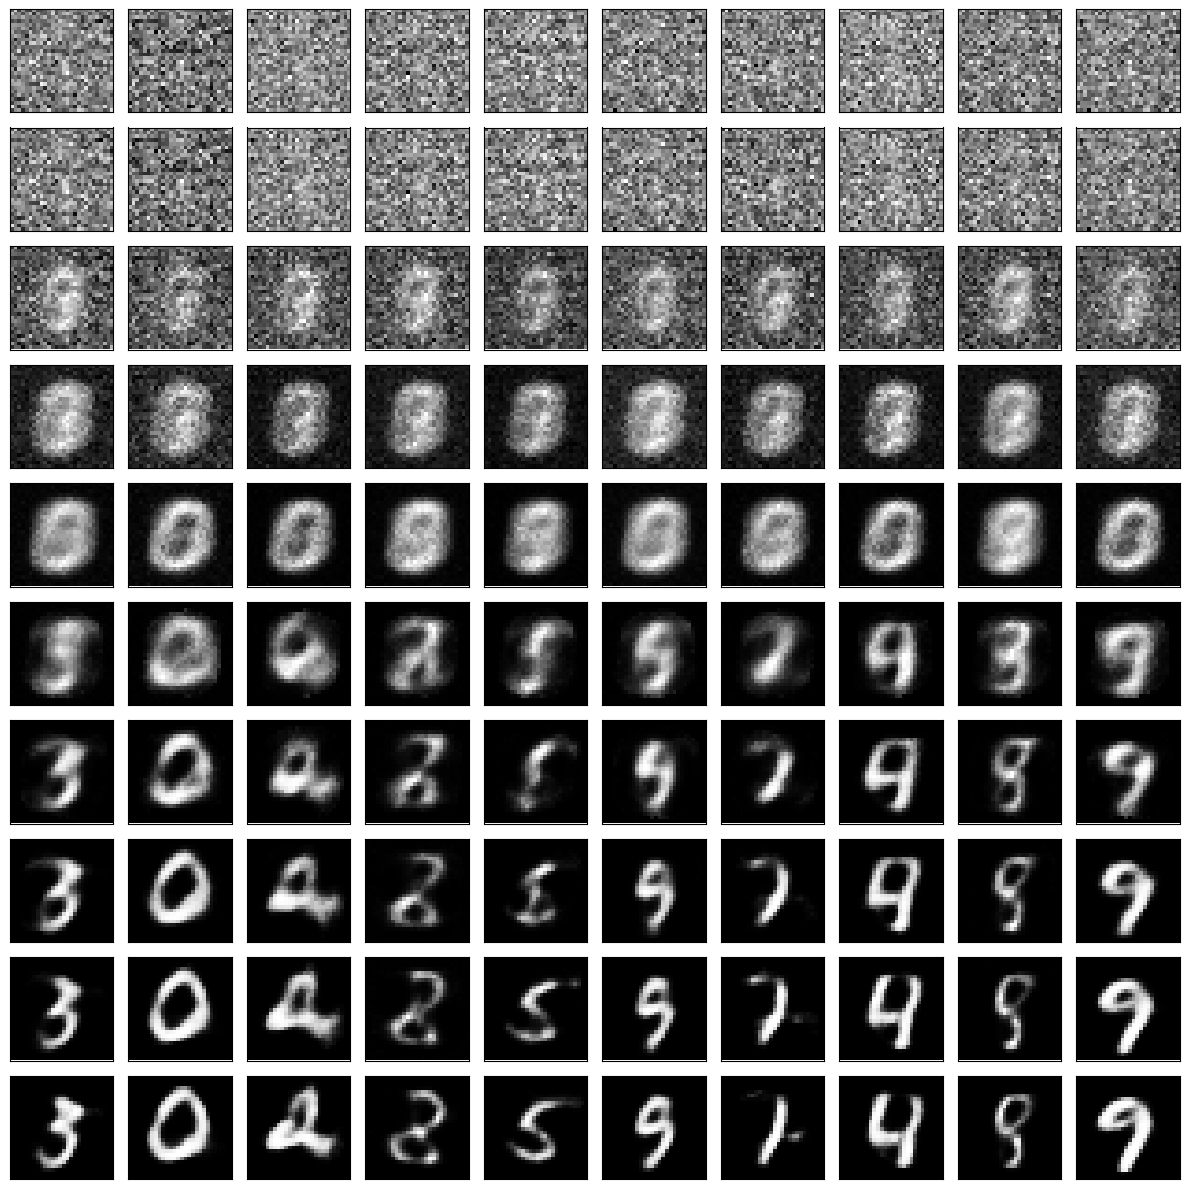

In [21]:
n = len(ss)

fig = plt.figure(figsize=(12,12))
for row, s in enumerate(ss):
    for col in range(10):
        ax = fig.add_subplot(n, 10, col + 10 * row + 1, xticks=[], yticks=[])

        img = samples[s][col].detach().cpu().numpy()
        
        img = img * 0.5 + 0.5

        img = np.transpose(img, (1, 2, 0))
        
        ax.imshow(img, cmap='gray')

        # Remove axes
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

plt.tight_layout()
plt.show()

*If you have time, you can try to explore the structure of the latent space, or perform interpolations in latent space.*